# 6.2 - Word2Vec example.

> Word2Vec, using this tutorial:

http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

https://github.com/nadbordrozd/blog_stuff/blob/master/classification_w2v/benchmarking.ipynb

> We want to benchmark a few machine learning classifiers to test if `Word2Vec` can improve text classification accuracy.

In [1]:
reset -fs

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import string
import re
import gensim
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import nltk
import nlp_ml_functions
import operator
from collections import Counter, defaultdict
from tabulate import tabulate
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import label_binarize, MultiLabelBinarizer, binarize, FunctionTransformer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
sns.set_style('white')

>Below is a class definition of classifiers using vector embeddings. We will implement an embedding vectorizer - a counterpart of CountVectorizer and TfidfVectorizer - that is given a word -> vector mapping and vectorizes texts by taking the mean of all the vectors corresponding to individual words.

In [3]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.values())
    
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
# and a tf-idf version of the same

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.values())
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer()
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

### Load dataframe.

In [4]:
balanced_df = pd.read_pickle("balanced_df")

In [5]:
article_counter = Counter(balanced_df['article_text'])

In [6]:
X_article = balanced_df['article_text']
y_article = balanced_df['relevance']

In [7]:
X_train_article, X_test_article, y_train_article, y_test_article = train_test_split(X_article, y_article, test_size=0.3, random_state=42)

### Creating a model.

In [8]:
model = gensim.models.Word2Vec(X_train_article)
model.index2word
w2v = dict(zip(model.index2word, model.syn0))

### Creating some machine learning pipelines.

In [9]:
mult_nb = Pipeline([("count_vectorizer", CountVectorizer(nlp_ml_functions.process_dataframe_text)), ("multinomial nb", MultinomialNB())])
bern_nb = Pipeline([("count_vectorizer", CountVectorizer(nlp_ml_functions.process_dataframe_text)), ("bernoulli nb", BernoulliNB())])
mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(nlp_ml_functions.process_dataframe_text)), ("multinomial nb", MultinomialNB())])
bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(nlp_ml_functions.process_dataframe_text)), ("bernoulli nb", BernoulliNB())])
svc = Pipeline([("count_vectorizer", CountVectorizer(nlp_ml_functions.process_dataframe_text)), ("linear svc", SVC(kernel="linear"))])
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(nlp_ml_functions.process_dataframe_text)), ("linear svc", SVC(kernel="linear"))])
logistic = Pipeline([("count_vectorizer", CountVectorizer(nlp_ml_functions.process_dataframe_text)), ("logistic", LogisticRegression())])
logistic_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(nlp_ml_functions.process_dataframe_text)), ("logistic", LogisticRegression())])
random_forest = Pipeline([("count_vectorizer", CountVectorizer(nlp_ml_functions.process_dataframe_text)), ("random forest", RandomForestClassifier())])
random_forest_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(nlp_ml_functions.process_dataframe_text)), ("random forest", RandomForestClassifier())])

### Below we use Extra Trees classifier using the custom embeddings.

In [10]:
etree_custom_emb = Pipeline([("mean embedding vectorizer", MeanEmbeddingVectorizer(article_counter)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_custom_emb_tfidf = Pipeline([("mean embedding vectorizer", TfidfEmbeddingVectorizer(article_counter)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

In [11]:
all_models = [
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ("logistic", logistic),
    ("logistic_tfidf", logistic_tfidf),
    ("random_forest", random_forest),
    ("random_forest_tfidf", random_forest_tfidf),
    ("mean_embedd", etree_custom_emb), 
    ("mean_embedd_tfidf", etree_custom_emb_tfidf),
    ("w2v", etree_w2v),
    ("w2v_tfidf", etree_w2v_tfidf),
]
scores_training = sorted([(name, cross_val_score(model, X_train_article, y_train_article, cv=5, scoring="roc_auc").mean()) 
                 for name, model in all_models], 
                key=operator.itemgetter(1),
                            reverse=True)
scores_testing = sorted([(name, cross_val_score(model, X_test_article, y_test_article, cv=5).mean()) 
                 for name, model in all_models], 
                key=operator.itemgetter(1),
                            reverse=True)

In [12]:
print(tabulate(scores_training, floatfmt=".2%", headers=("Model", 'ROC AUC Training Score')))

Model                  ROC AUC Training Score
-------------------  ------------------------
svc_tfidf                              81.88%
bern_nb                                80.79%
bern_nb_tfidf                          80.79%
logistic_tfidf                         80.60%
mult_nb                                80.19%
mult_nb_tfidf                          79.68%
logistic                               79.20%
random_forest                          78.97%
w2v                                    78.55%
w2v_tfidf                              78.30%
svc                                    78.15%
random_forest_tfidf                    77.39%
mean_embedd                            50.00%
mean_embedd_tfidf                      50.00%


In [13]:
print(tabulate(scores_testing, floatfmt=".2%", headers=("Model", 'ROC AUC Testing Score')))

Model                  ROC AUC Testing Score
-------------------  -----------------------
mult_nb                               68.75%
bern_nb                               67.08%
bern_nb_tfidf                         67.08%
logistic_tfidf                        66.11%
svc_tfidf                             64.59%
mult_nb_tfidf                         63.33%
logistic                              61.81%
svc                                   60.01%
random_forest                         59.31%
w2v                                   59.30%
w2v_tfidf                             58.74%
random_forest_tfidf                   58.47%
mean_embedd                           50.83%
mean_embedd_tfidf                     50.83%


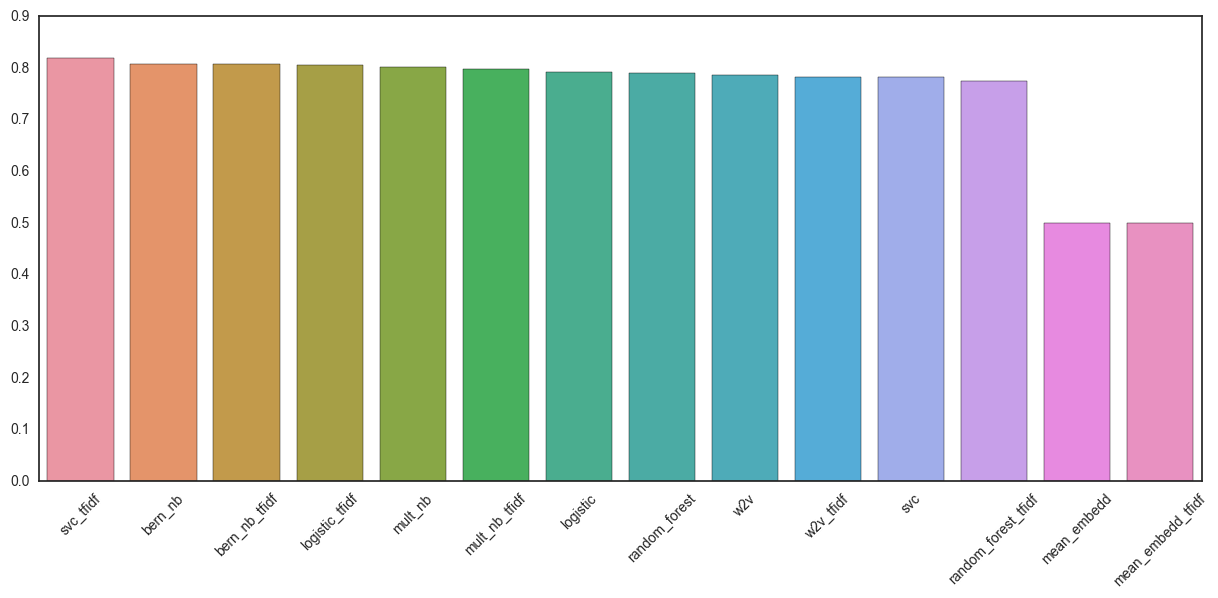

In [14]:
plt.figure(figsize=(15, 6))
plot = sns.barplot(x=[name for name, _ in scores_training], y=[score for _, score in scores_training])
plt.setp(plot.get_xticklabels(), rotation=45);

In [15]:
def benchmark(model, X, y, n):
    test_size = 1 - (n / float(len(y)))
    scores = []
    X = np.array(X)
    y = np.array(y)
    sss =  StratifiedShuffleSplit(n_splits=5, test_size=test_size)
    for train, test in sss.split(X, y):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        #scores.append(f1_score(model.fit(X_train, y_train).predict(X_test), y_test))
        scores.append(accuracy_score(y_test, model.fit(X_train, y_train).predict(X_test)))
    return np.mean(scores)

### Now ranking based on different training sizes.

In [16]:
train_sizes = [10, 20, 40, 80, 160, 320, 640, 1280, 1500, 2000]
table = []
for name, model in all_models:
    for n in train_sizes:
        table.append({'model': name, 
                      'accuracy': benchmark(model, X_article, y_article, n), 
                      'train_size': n})
df = pd.DataFrame(table)

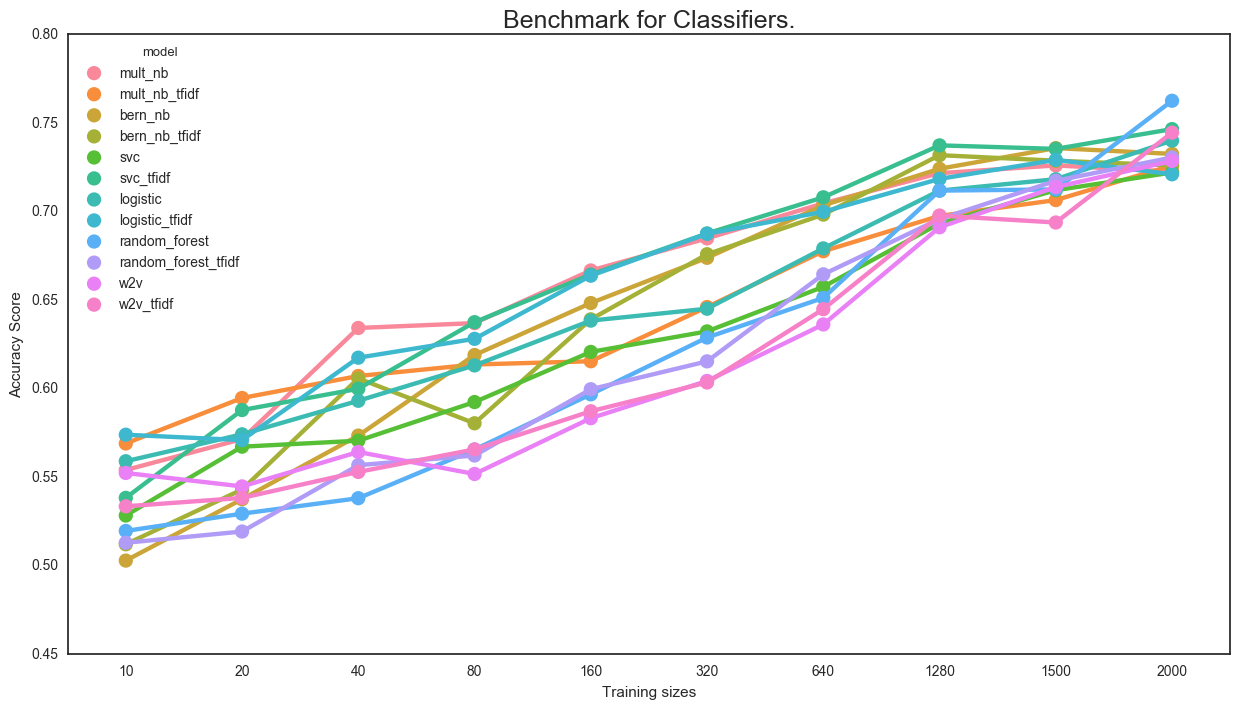

In [17]:
plt.figure(figsize=(15, 8))
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', 
                    data=df[df.model.map(lambda x: x in ["mult_nb", "mult_nb_tfidf","svc","svc_tfidf", "bern_nb",
                                                         "bern_nb_tfidf", "logistic", "logistic_tfidf", "w2v",
                                                         "w2v_tfidf", "random_forest", "random_forest_tfidf",
                                                         "etree_custom_emb", "etree_custom_emb_tfidf", 
                                                        ])])
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="Accuracy Score")
fig.set(xlabel="Training sizes")
fig.set(title="Benchmark for Classifiers.");